In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import glob
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Adapted from https://github.com/AI-Cloud-and-Edge-Implementations/Project15-G4/blob/master/elephantcallscounter/data_transformations/filters.py

from matplotlib import pyplot as plt
import scipy
from scipy.signal import butter


class Filters:
    @classmethod
    def butter_lowpass_filter(cls, data, cutoff, nyq, order, sampling_frequency, time, plot = False):
        """ Lowpass filter for the input signal.
        :param data:
        :type data: librosa.Audio
        :param cutoff: 
        :type cutoff: int
        :param nyq: 
        :type nyq: float
        :param order: 
        :type order: int
        :param sampling_frequency: 
        :type sampling_frequency: float
        :param time: 
        :type time: ndarray
        :param plot: defaults to False
        :type plot: bool, optional
        :return: 
        :rtype: librosa.Audio
        """
        normalized_cutoff = cutoff / nyq
        numerator_coeffs, denominator_coeffs = scipy.signal.butter(order, normalized_cutoff, btype='low', analog=False, fs=sampling_frequency)
        filtered_signal = scipy.signal.lfilter(numerator_coeffs, denominator_coeffs, data)
        if plot:
            plt.plot(time, data, 'b-', label = 'signal')
            plt.plot(time, filtered_signal, 'g-', linewidth = 2, label = 'filtered signal')
            plt.legend()
            plt.show()
        return filtered_signal


    @classmethod
    def butter_highpass_filter(cls, data, cutoff, nyq, order, sampling_frequency, time, plot = False):
        """ High pass filter for the input signal.
        :param data: 
        :type data: librosa.Audio
        :param cutoff: 
        :type cutoff: int
        :param nyq: 
        :type nyq: float
        :param order: 
        :type order: int
        :param sampling_frequency: 
        :type sampling_frequency: float
        :param time: 
        :type time: ndarray
        :param plot: defaults to False
        :type plot: bool, optional
        :return: 
        :rtype: librosa.Audio
        """
        normalized_cutoff = cutoff / nyq
        numerator_coeffs, denominator_coeffs = scipy.signal.butter(order, normalized_cutoff, btype='high', analog=False, fs=sampling_frequency)
        filtered_signal = scipy.signal.lfilter(numerator_coeffs, denominator_coeffs, data)
        if plot:
            plt.plot(time, data, 'b-', label = 'signal')
            plt.plot(time, filtered_signal, 'g-', linewidth = 2, label = 'filtered signal')
            plt.legend()
            plt.show()
        return filtered_signal

In [ ]:
def plot_audio(path, spectrogram_dir, cutoff=100,
                n_fft=2048, hop_length=512, n_mels=128, window_length=2048,
                use_linear_for_mel=False,
                extra_power=1,
                htk=False,
                display=False,
                y_max=None,
                f_max=None,
                dz=False,
                elp=False):
    basename = os.path.splitext(os.path.basename(path))[0]
    window_length = window_length or n_fft
    hop_length = hop_length or window_length//4
    input_data, sampling_frequency = librosa.load(path)
    
    # Adapted from https://github.com/AI-Cloud-and-Edge-Implementations/Project15-G4/blob/8f16003ce1e6aa0658bb71e91c7180a4729348fb/elephantcallscounter/data_analysis/analyse_sound_data.py
    duration = len(input_data) / sampling_frequency
    # plots upto sampling rate/2(Nyquist theorem)
    # Filter requirements.
    fs = sampling_frequency  # sample rate, Hz
    nyq = 0.5  # Nyquist Frequency
    order = 4  # sin wave can be approx represented as quadratic
    time = np.linspace(0, duration, len(input_data), endpoint=False)

    lowpass_signal = Filters.butter_lowpass_filter(
        input_data, cutoff, nyq, order, sampling_frequency, time, plot=False)

    cutoff_high = 10
    highpass_signal = Filters.butter_highpass_filter(
        lowpass_signal, cutoff_high, nyq, order, sampling_frequency, time, plot=False
    )
    spectrogram = librosa.feature.melspectrogram(
        y=highpass_signal, sr=fs, n_fft=n_fft,
        hop_length=hop_length, n_mels=n_mels, htk=htk,
        win_length=window_length,
        fmax=f_max
    )
    spectrogram = spectrogram ** extra_power
    if y_max is None or y_max > fs / 2:
        y_max = fs / 2
    fig, ax = plt.subplots()
    img = librosa.display.specshow(
        spectrogram, ax=ax, sr=sampling_frequency,
        hop_length=hop_length, x_axis='s', y_axis='linear' if use_linear_for_mel else 'mel',
        htk=htk
    )
    ax.set_yscale('linear')
    plt.ylim([0, y_max])
    buffer = 3
    end_buffer = duration - buffer
    if display:
        if dz:
            ax.set_title(basename)
        if elp:
            plt.axvline(x=buffer, ls='dashed')
            plt.axvline(x=end_buffer, ls='dashed')
        plt.show()
    else:
        plt.axis('off')
        plt.savefig(os.path.join(spectrogram_dir, f'{basename}.png'), transparent=True, bbox_inches='tight', pad_inches=0)
        plt.cla()
        plt.clf()
        plt.close('all')
        del img, spectrogram, input_data, lowpass_signal, highpass_signal, time
        gc.collect()

In [ ]:
BASE_ELP_DIR = '../elp_data'
BASE_DZ_DIR = '../dzanga-bai-20210816T230919Z-001/dzanga-bai'

def all_wav_to_spectrogram(wav_dir, spectrogram_dir, start=0, limit=25, **kwargs):
    # Store all wav files as Path objects
    wav_paths = sorted(glob.glob(os.path.join(wav_dir, '*.wav')))[start:]
    if limit is not None:
        wav_paths = wav_paths[:limit]

    # keep a track of the last successful index so we can run in batch
    # dont rerun
    for i, p in enumerate(wav_paths):
        plot_audio(p, spectrogram_dir, **kwargs)
        if limit is None or limit > 25:
            print(f'Completed: {i} {p}')


def main(elp=True, dz=False, **kwargs):
    if elp:
        all_wav_to_spectrogram(os.path.join(BASE_ELP_DIR, 'short_wav_files_3'),
                               os.path.join(BASE_ELP_DIR, 'test_spectrograms'),
                               elp=True, dz=False, **kwargs)
    if dz:
        all_wav_to_spectrogram(os.path.join(BASE_DZ_DIR, 'raw_wav'),
                               os.path.join(BASE_DZ_DIR, 'high_filtered_spectrograms'),
                               elp=False, dz=True, **kwargs)

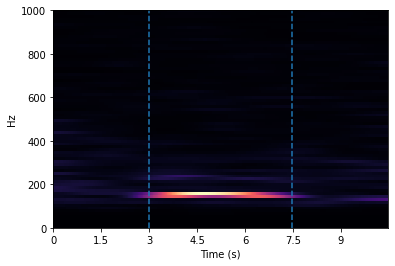

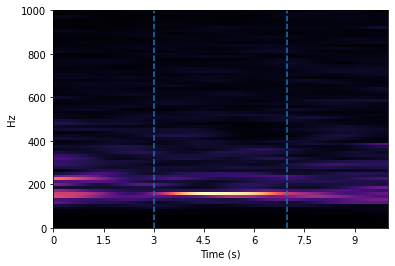

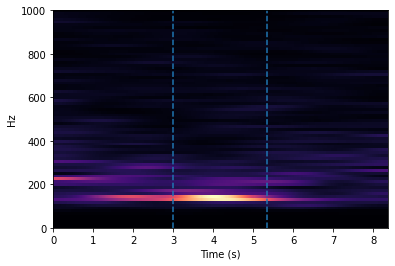

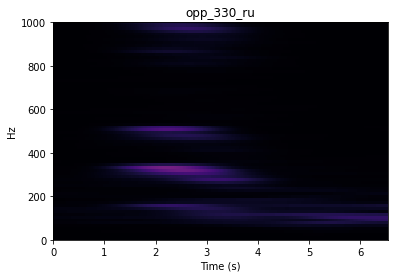

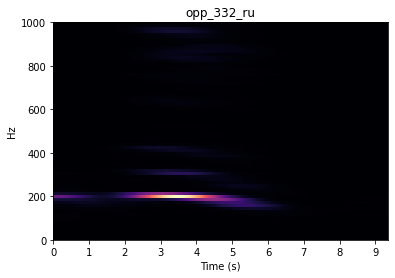

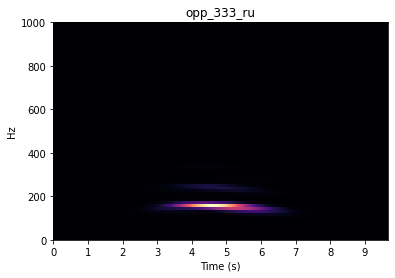

Done


In [ ]:
main(cutoff=500, 
     n_mels=250, 
     n_fft=int(22050/0.98*4), 
     hop_length=int(0.0255*22050/0.98),
     window_length=None, 
     extra_power=0.9,
     y_max=1000,
     f_max=500,
     htk=False,
     use_linear_for_mel=False, 
     display=True,
     start=0, 
     elp=True, 
     dz=True, 
     limit=3)   # first 3 are elp, next 3 are dz
print('Done')